# Isovalent Hackathon 2025: eBPF Scheduler Performance Analysis

This notebook presents a comprehensive data analysis of the benchmarks performed on SCX_MUS, a custom Linux scheduler developed for the Isovalent Hackathon 2025.

## 1. Context and Objective

In multi-tenant Kubernetes environments, latency-sensitive applications often suffer from the "noisy neighbor" effect, where background processes starve critical workloads of CPU time. The standard Linux scheduler (CFS - Completely Fair Scheduler) aims for fairness, which is not always ideal for critical latency requirements.

The objective of this project is to leverage sched_ext, an extensible scheduler framework for the Linux kernel, to implement a custom BPF-based scheduler. This scheduler is designed to identify specific Kubernetes pods (via Cgroups) and enforce strict prioritization policies, ensuring low latency even under heavy CPU contention.

## 2. Experimental Methodology

To validate the scheduler's efficiency, we designed a controlled benchmark environment consisting of two isolated physical hosts:


- **Host 1 (System Under Test - SUT)**:

  - **Environment**: Kubernetes (K3s) cluster running on a Linux Kernel with sched_ext support.

  - **Target Workload**: A Redis container (latency-sensitive).

  - **Noise Generator**: A stress-ng container designed to saturate CPU resources, simulating a noisy neighbor scenario.

  - **Scheduler**: Runs the runner binary which loads the eBPF program into the kernel.

- **Host 2 (Load Generator)**:

  - **Tooling**: A Python automation script wrapping memtier_benchmark.

  - **Function**: Generates consistent traffic patterns towards Host 1 to measure response times and throughput without local interference.

## 3. Test Scenarios

We conducted a comparative analysis between the standard Linux scheduler (CFS) and our custom solution (EXT/Vanguard). The dataset consists of 5 distinct scenarios, with 50 independent benchmark runs for each to ensure statistical significance.

The scenarios are defined as follows:

| ID         | Scheduler      | Environment State | Description                                                                 |
|------------|----------------|-------------------|-----------------------------------------------------------------------------|
| CFS_Normal   | CFS (Standard) | Idle (No Noise)   | Baseline performance of Redis using the standard kernel scheduler without interference. |
| CFS_Stress | CFS (Standard) | CPU Saturated     | Redis competing for cycles against stress-ng under the standard scheduler. |
| CFS_redis_priority-17 | CFS (Standard) | CPU Saturated     | Redis competing for cycles against stress-ng under the standard scheduler. Redis processes has a nice value of -17 (more priority). |
| MUS_Normal   | SCX_VANGUARD   | Idle (No Noise)   | Baseline performance of Redis using our custom BPF scheduler to ensure no regression in normal conditions. |
| MUS_Stress | SCX_VANGUARD   | CPU Saturated     | Redis competing against stress-ng, but prioritized by our custom scheduler. |

The experiments were executed on **Magalu Cloud** virtual machines.
Host 1 used a BV4-8-20 instance (4 vCPUs, 8 GB RAM), and Host 2 used a BV2-2-20 instance (2 vCPUs, 2 GB RAM). Both machines ran Ubuntu 24.04.

## 4. Dataset Attribute Definitions

The dataset generated by the benchmarks consists of the following column prefixes and metrics:

**Prefixes (Operation Types)**

- **sets_ (Write)**: Metrics related to SET commands (writing or overwriting data).

- **gets_ (Read)**: Metrics related to GET commands (retrieving data).

- **tot_ (Total)**: Aggregated statistics for both Write and Read operations.

**Metrics**

- **run**: Identifier for the benchmark iteration (1 to 50).

- **ops (Ops/sec)**: Throughput. The number of operations processed per second. Higher is better.

- **hits / misses**: Cache hit/miss rates per second (applicable only to GET operations).

- **avg_lat (Average Latency)**: The mean response time. $$\frac{\sum t}{n}$$

- **p50 (Median)**: The 50th percentile. Represents the latency experienced by a typical request (stability).

- **p99 (Tail Latency)**: The 99th percentile. Indicates that 99% of requests were faster than this value.

- **p999 (Deep Tail Latency)**: The 99.9th percentile. Represents extreme outliers, often caused by severe context switching delays or blocked resources.

- **kb (Bandwidth)**: Kilobytes per second transferred. Used to verify if the bottleneck is network-related rather than CPU-related.

## 5. Goal of Analysis

The primary goal of this notebook is to visualize and quantify the impact of the custom scheduler.

By comparing the distributions of these metrics, we aim to prove that SCX_VANGUARD effectively isolates critical workloads from CPU starvation.

For more informations, check our repo: https://github.com/patos-ufscar/Hackathon-eBPF-2025

---



In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
df_cfs_normal = pd.read_csv('/content/results_CFS_normal.csv')
df_cfs_stress = pd.read_csv('/content/results_CFS_stress.csv')
df_mus_normal = pd.read_csv('/content/results_EXT_normal.csv')
df_mus_stress = pd.read_csv('/content/results_EXT_stress.csv')

df_cfs_redis_priority_17 = pd.read_csv('/content/results_CFS_redis_priority-17.csv')

df_mus_stress.head()

,run,sets_ops,sets_hits,sets_misses,sets_avg_lat,sets_p50,sets_p99,sets_p999,sets_kb,gets_ops,...,gets_p999,gets_kb,tot_ops,tot_hits,tot_misses,tot_avg_lat,tot_p50,tot_p99,tot_p999,tot_kb
0,1,9129.28,0.0,0.0,0.879,0.695,6.559,10.943,1568.05,36514.15,...,10.943,1426.60,45643.42,33.33,36480.82,0.0,0.695,6.399,10.943,2994.66
1,2,8100.22,0.0,0.0,0.988,0.703,8.319,11.199,1391.31,32398.46,...,11.263,1266.01,40498.68,31.06,32367.40,0.0,0.703,8.319,11.199,2657.32
2,3,8673.26,0.0,0.0,0.922,0.687,8.095,11.263,1489.74,34690.38,...,11.199,1355.40,43363.64,32.00,34658.38,0.0,0.687,8.095,11.199,2845.14
3,4,8947.14,0.0,0.0,0.895,0.695,7.391,11.007,1536.78,35785.90,...,11.071,1398.22,44733.04,33.20,35752.70,0.0,0.695,7.423,11.071,2935.00
4,5,8627.09,0.0,0.0,0.897,0.711,6.943,10.559,1481.81,34505.92,...,10.687,1348.22,43133.01,32.09,34473.83,0.0,0.711,6.911,10.623,2830.03


In [ ]:
df_cfs_stress.columns

Index(['run', 'sets_ops', 'sets_hits', 'sets_misses', 'sets_avg_lat',
       'sets_p50', 'sets_p99', 'sets_p999', 'sets_kb', 'gets_ops', 'gets_hits',
       'gets_misses', 'gets_avg_lat', 'gets_p50', 'gets_p99', 'gets_p999',
       'gets_kb', 'tot_ops', 'tot_hits', 'tot_misses', 'tot_avg_lat',
       'tot_p50', 'tot_p99', 'tot_p999', 'tot_kb'],
      dtype='object')

# Performance Analysis

The following visualizations illustrate the distribution of the avarege latency of the target machine on our test scenario (atributte gets_avg_lat). Note that the 4 tests are in the same plot, but the most important is to compare CFS Normal vs. MUS Normal (tests without stress, only the redis container running on our kubernetes) and CFS Stress vs MUS Stress (kubernetes running Redis and Stress_noise).

### CFS Normal x MUS Normal

In the "Normal" scenario (no background noise), SCX_MUS shows no significant performance gain over the standard CFS. In fact, CFS occasionally yields slightly lower latency due to its highly optimized handling of unburdened CPUs. However, SCX_MUS demonstrates a consistent execution pattern, confirming that the overhead of the custom BPF scheduler is negligible under standard conditions.

### CFS Stress x MUS Stress

This scenario highlights the core value of our project. SCX_MUS significantly outperforms CFS under heavy CPU stress.

This performance gap is a direct result of the strict prioritization logic applied to the Redis container. Standard CFS optimizes for fairness, which leads to the Redis workload waiting in line behind background noise tasks. Since SCX_MUS enforces priority, the critical workload is processed immediately.

Howeve, this scenario hides something important, only our scheduler is prioritizing the tasks in the container, CFS can prioritize too (and in this case, it is the `nice` default value, 0). To ensure a rigorous comparison, it is essential to benchmark our scheduler against a CFS test with priority on Redis container too.


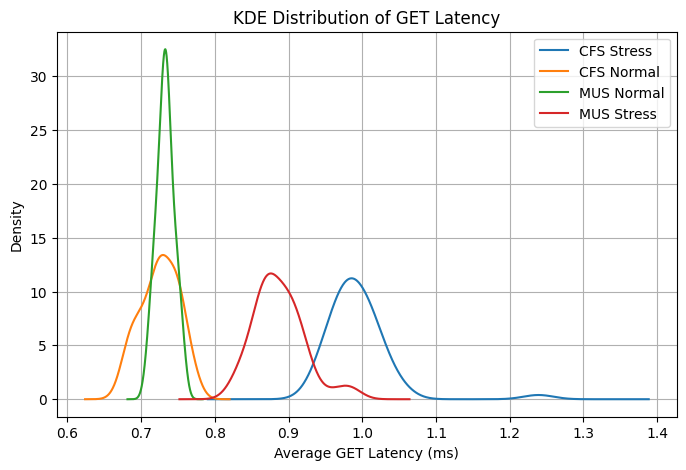

In [3]:
plt.figure(figsize=(8,5))

df_cfs_stress['gets_avg_lat'].plot(kind='density', label='CFS Stress')
df_cfs_normal['gets_avg_lat'].plot(kind='density', label='CFS Normal')
df_mus_normal['gets_avg_lat'].plot(kind='density', label='MUS Normal')
df_mus_stress['gets_avg_lat'].plot(kind='density', label='MUS Stress')

plt.xlabel('Average GET Latency (ms)')
plt.ylabel('Density')
plt.title('KDE Distribution of GET Latency')
plt.legend()
plt.grid(True)

plt.show()



## Throughput Distribution (Violin Plot)

The violin plot visualizes the bandwidth stability and density for each test. As expected, scenarios without stress achieve higher overall throughput. However, under stress conditions, SCX_MUS maintains a much healthier throughput profile compared to the throttled performance observed in the standard CFS stress test. This correlates with the lower latency results, confirming that prioritization preserves both responsiveness and data volume.

/tmp/ipython-input-3472476705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Test Group', y='Bandwidth (KB)', data=df_long, palette="Set3")


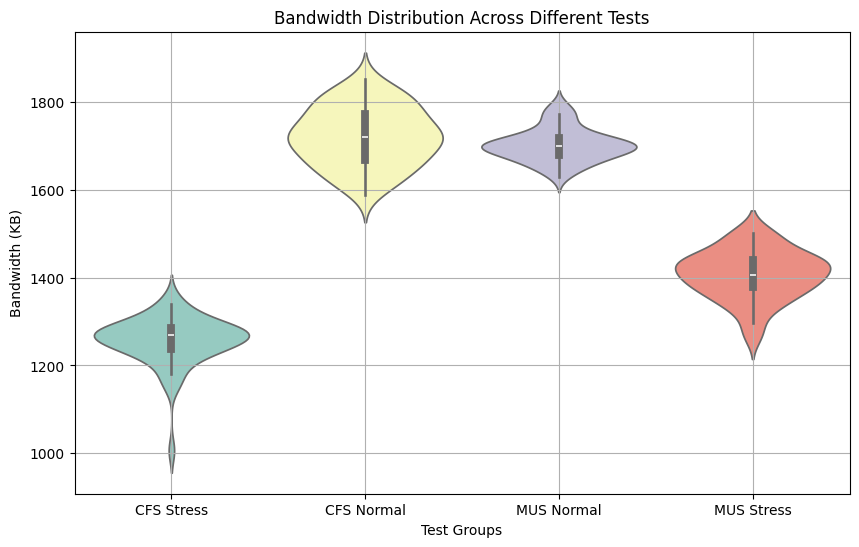

In [ ]:
df_combined = pd.DataFrame({
    'CFS Stress': df_cfs_stress['gets_kb'],
    'CFS Normal': df_cfs_normal['gets_kb'],
    'MUS Normal': df_mus_normal['gets_kb'],
    'MUS Stress': df_mus_stress['gets_kb']
})

df_long = df_combined.melt(var_name='Test Group', value_name='Bandwidth (KB)')

plt.figure(figsize=(10, 6))
sns.violinplot(x='Test Group', y='Bandwidth (KB)', data=df_long, palette="Set3")

plt.xlabel('Test Groups')
plt.ylabel('Bandwidth (KB)')
plt.title('Bandwidth Distribution Across Different Tests')

plt.grid(True)
plt.show()

## Comparative Study: SCX_MUS vs. CFS (Nice -17)

In this graph, we can see that even when assigning a nice value of –17 to the Redis process, CFS does not show a significant performance improvement compared to its behavior at nice 0. The only noticeable difference is the absence of extreme outliers, those rare cases where latency becomes dramatically worse.

However, we cannot determine from this dataset whether this improvement is a consistent characteristic of CFS under a high-priority nice value or simply an artifact of this particular test run. More samples would be required to confirm whether the reduction in outliers is reproducible or merely noise in the measurement.

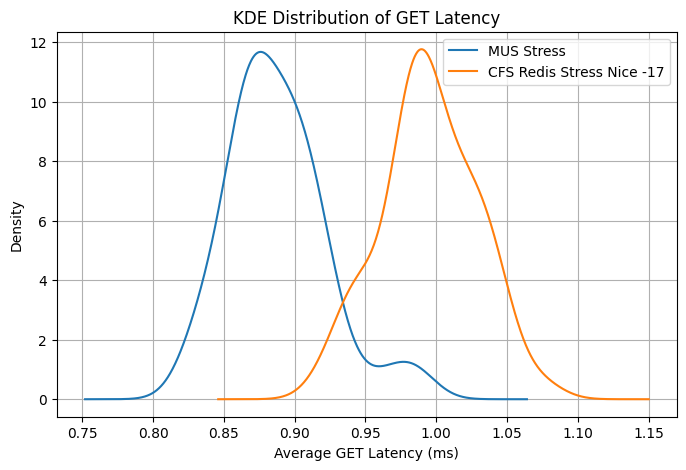

In [4]:
plt.figure(figsize=(8,5))

df_mus_stress['gets_avg_lat'].plot(kind='density', label='MUS Stress')
df_cfs_redis_priority_17['gets_avg_lat'].plot(kind='density', label='CFS Redis Stress Nice -17')

plt.xlabel('Average GET Latency (ms)')
plt.ylabel('Density')
plt.title('KDE Distribution of GET Latency')
plt.legend()
plt.grid(True)

plt.show()

## P999 Comparison

At first glance, this plot may look surprising. You might think there's an error, especially since we’ve already seen that MUS performs better under stress in terms of average latency. But here’s the catch: the earlier plots only showed means, not the worst-case behavior.

The P999 results reveal something the averages fail to show: MUS can experience significant latency spikes. This indicates that our implementation has performance bottlenecks that only surface in extreme cases. The most likely sources are migration overhead and slow context-switch handling—especially because SCX_MUS lacks a sophisticated mechanism to manage these behaviors and is intentionally much simpler. In specific scenarios, MUS is likely hit by particularly costly context switches or migration delays, causing it to perform worse than CFS at the tail of the distribution.

In other words: MUS may be fast on average, but its worst-case latency is significantly less stable than CFS.

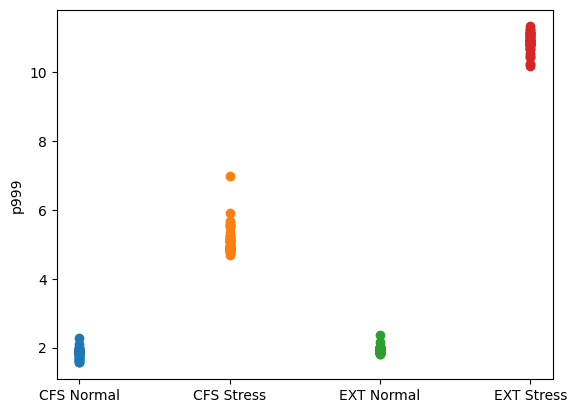

In [ ]:
dfs = [df_cfs_normal, df_cfs_stress, df_mus_normal, df_mus_stress]
labels = ['CFS Normal', 'CFS Stress', 'MUS Normal', 'MUS Stress']

for i, df in enumerate(dfs):
    plt.scatter([i]*len(df['gets_p999']), df['gets_p999'])

plt.xticks(range(len(labels)), labels)
plt.ylabel('P999')
plt.show()

## Conclusion

Overall, our analysis shows that SCX_MUS delivers promising results, particularly in terms of average latency and stability under certain workloads. While it does not consistently outperform CFS—nor was that ever the primary goal—the project demonstrates that it is entirely possible for students to design and implement a working scheduler, explore alternative ideas, and obtain meaningful performance characteristics.

The intention behind SCX_MUS was not to replace or surpass the maturity of CFS, but to experiment, learn, and validate new approaches to scheduling. In that sense, the project was highly successful: it highlights that fresh designs can be prototyped, tested, and evaluated in real kernel environments.